In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights
from transformers import AutoTokenizer, AutoModel
import numpy as np
from PIL import Image
import os
import pandas as pd
import json
from tqdm import tqdm

In [2]:
class CLIPConfig:
    def __init__(self):
        self.embed_dim = 512
        self.num_head = 8
        self.dropout = 0.1
        self.temperature = 0.7
        self.batch_size = 64
        self.epochs = 10
        self.lr = 1e-4
        self.weight_decay = 3e-5
        self.warmup_steps = 500
        self.max_grad_norm = 1.0
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.log_interval = 50
        self.eval_interval = 2
        self.use_amp = True

config = CLIPConfig()



In [3]:
class ProjectionHead(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dim = 2048, dropout = 0.1):
        super(ProjectionHead, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, out_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(out_dim, out_dim),
        )
    def forward(self, x):
        return self.mlp(x)

In [4]:
class CLIP(nn.Module):
    def __init__(self, config):
        super(CLIP, self).__init__()
        self.config = config

        weight = ResNet50_Weights.IMAGENET1K_V2
        self.image_encoder = resnet50(weights = weight)
        self.image_encoder.fc = nn.Identity()
        self.image_projection = ProjectionHead(in_dim= 2048, out_dim= config.embed_dim, dropout= config.dropout)


        self.tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
        self.text_encoder = AutoModel.from_pretrained('bert-base-uncased')
        self.text_projection = ProjectionHead(in_dim= 768, out_dim=config.embed_dim, dropout= config.dropout)

        #Tempertature
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1/ config.temperature))

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)

    def encode_image(self, images):
        features = self.image_encoder(images)
        projected = self.image_projection(features)
        return F.normalize(projected, dim = -1)

    def encode_text(self, text):
        inputs = self.tokenizer(text, return_tensors = "pt", padding = True, truncation = True, max_length = 77)
        input_ids = inputs["input_ids"].to(self.config.device)
        attention_mask = inputs['attention_mask'].to(self.config.device)

        outputs = self.text_encoder(input_ids = input_ids, attention_mask = attention_mask)
        pooled_output = outputs.pooler_output
        projected = self.text_projection(pooled_output)
        return F.normalize(projected, dim = -1)

    def forward(self, images, texts):
        images_features = self.encode_image(images)
        text_features = self.encode_text(texts)
        return images_features, text_features




In [5]:
def compute_logits(image_features, text_features, logit_scale):
    return logit_scale.exp() * image_features @ text_features.T

In [6]:
def contrastive_loss(logits):
    labels = torch.arange(len(logits), device=logits.device)
    loss_i2t = F.cross_entropy(logits, labels)
    loss_t2i = F.cross_entropy(logits.T, labels)
    return (loss_i2t + loss_t2i) / 2


In [7]:
def recall_at_k(sim_matrix, query_indices, k=5):
    top_k = np.min((k, sim_matrix.shape[1]))
    top_k_indices = np.argpartition(sim_matrix, -top_k, axis=1)[:, -top_k:]
    recalls = []
    for i, true_idx in enumerate(query_indices):
        if true_idx in top_k_indices[i]:
            recalls.append(1)
        else:
            recalls.append(0)
    return np.mean(recalls)

In [8]:
class Flickr8kDataset(Dataset):
    def __init__(self, csv_file, image_dir, split="train", transform=None):
        self.image_dir = image_dir

        self.transform = transform or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.48145466, 0.4578275, 0.40821073],
                std=[0.26862954, 0.26130258, 0.27577711]
            )
        ])

        df = pd.read_csv(csv_file)
        df.columns = ["ImageName", "Comment"]

        unique_imgs = df["ImageName"].unique()
        np.random.seed(42)
        train_imgs = np.random.choice(unique_imgs, int(0.95 * len(unique_imgs)), replace=False)
        val_imgs = np.setdiff1d(unique_imgs, train_imgs)

        if split == "train":
            self.df = df[df["ImageName"].isin(train_imgs)].reset_index(drop=True)
        else:
            self.df = df[df["ImageName"].isin(val_imgs)].reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_dir, row["ImageName"])

        try:
            image = Image.open(img_path).convert("RGB")
        except:
            image = Image.new("RGB", (224, 224), color="gray")

        image = self.transform(image)
        caption = row["Comment"]

        return image, caption


In [9]:
class WarmupLinearSchedule(optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, warmup_steps, total_steps, last_epoch=-1):
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.last_epoch < self.warmup_steps:
            lr_mult = float(self.last_epoch) / float(max(1, self.warmup_steps))
        else:
            lr_mult = 1.0 - float(self.last_epoch - self.warmup_steps) / float(max(1, self.total_steps - self.warmup_steps))
        return [base_lr * lr_mult for base_lr in self.base_lrs]

In [10]:
def evaluate_retrieval(model, val_dataloader, k_values=[1, 5, 10]):
    model.eval()
    all_image_features = []
    all_text_features = []

    with torch.no_grad():
        for images, captions in tqdm(val_dataloader, desc='Encoding for eval'):
            images = images.to(config.device)

            i_feats = model.encode_image(images)
            t_feats = model.encode_text(captions)

            all_image_features.append(i_feats.cpu())
            all_text_features.append(t_feats.cpu())

    all_image_features = torch.cat(all_image_features)
    all_text_features  = torch.cat(all_text_features)

    logits = (all_image_features @ all_text_features.T).numpy()

    N = logits.shape[0]
    true_indices = list(range(N))  # correct 1:1 pairing

    recalls = {}
    for k in k_values:
        recalls[f'R@{k} (i2t)'] = recall_at_k(logits, true_indices, k=k)
        recalls[f'R@{k} (t2i)'] = recall_at_k(logits.T, true_indices, k=k)

    return recalls




def train_clip(model, optimizer, train_loader, val_loader, config):
    device = config.device
    model.to(device)
    scaler = torch.amp.GradScaler('cuda')

    total_steps = len(train_loader) * config.epochs
    scheduler = WarmupLinearSchedule(optimizer, config.warmup_steps, total_steps)

    global_step = 0
    for epoch in range(config.epochs):
        model.train()
        total_loss = 0
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{config.epochs}')

        for batch_idx, (images, captions) in enumerate(pbar):
            images = images.to(device)
            captions = list(captions)  # List of strings

            optimizer.zero_grad()


            #AMP
            with torch.amp.autocast('cuda'):
                image_features, text_features = model(images, captions)
                logits = compute_logits(image_features, text_features, model.logit_scale)
                loss = contrastive_loss(logits)


            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), config.max_grad_norm)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

            total_loss += loss.item()
            global_step += 1

            pbar.set_postfix({'Loss': f'{loss.item():.4f}', 'LR': f'{scheduler.get_last_lr()[0]:.2e}'})

            if global_step % config.log_interval == 0:
                print(f'Step {global_step}: Loss = {loss.item():.4f}')

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1} completed. Avg Loss: {avg_loss:.4f}')

        if (epoch + 1) % config.eval_interval == 0:
            recalls = evaluate_retrieval(model, val_loader)
            print(f'Eval Metrics: {recalls}')

    return model

In [11]:
import kagglehub

path = kagglehub.dataset_download("adityajn105/flickr8k")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\modam\.cache\kagglehub\datasets\adityajn105\flickr8k\versions\1


In [12]:
root = r"C:\Users\modam\.cache\kagglehub\datasets\adityajn105\flickr8k\versions\1"

train_dataset = Flickr8kDataset(
    csv_file=f"{root}\\captions.txt",
    image_dir=f"{root}\\Images",
    split="train"
)

val_dataset = Flickr8kDataset(
    csv_file=f"{root}\\captions.txt",
    image_dir=f"{root}\\Images",
    split="val"
)


train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)

print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}")


Train size: 38430, Val size: 2025


In [13]:
model = CLIP(config)
for name, p in model.image_encoder.named_parameters():
    if 'layer4' in name:
        p.requires_grad = True
for name, p in model.text_encoder.named_parameters():
    if 'encoder.layer.11' in name or 'pooler' in name:
        p.requires_grad = True

In [14]:
trainable = sum(p.requires_grad for p in model.parameters())
total = sum(1 for _ in model.parameters())
print(trainable, "/", total)


371 / 371


In [15]:
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=config.lr, weight_decay=config.weight_decay)

trained_model = train_clip(model, optimizer, train_loader, val_loader, config)

torch.save({
        'model_state_dict': trained_model.state_dict(),
        'config': config.__dict__,
        'logit_scale': trained_model.logit_scale.item()
    }, 'flickr8k_clip_pretrained.pth')
print("Flickr8k pretraining complete. Model saved as 'flickr8k_clip_pretrained.pth'.")

Epoch 1/10:   8%|▊         | 50/601 [00:14<02:35,  3.55it/s, Loss=4.1476, LR=1.00e-05]

Step 50: Loss = 4.1476


Epoch 1/10:  17%|█▋        | 100/601 [00:28<02:20,  3.55it/s, Loss=3.7481, LR=2.00e-05]

Step 100: Loss = 3.7481


Epoch 1/10:  25%|██▍       | 150/601 [00:42<02:06,  3.55it/s, Loss=3.5893, LR=3.00e-05]

Step 150: Loss = 3.5893


Epoch 1/10:  33%|███▎      | 200/601 [00:56<01:52,  3.57it/s, Loss=3.5164, LR=4.00e-05]

Step 200: Loss = 3.5164


Epoch 1/10:  42%|████▏     | 250/601 [01:10<01:38,  3.57it/s, Loss=3.6251, LR=5.00e-05]

Step 250: Loss = 3.6251


Epoch 1/10:  50%|████▉     | 300/601 [01:24<01:24,  3.58it/s, Loss=3.5507, LR=6.00e-05]

Step 300: Loss = 3.5507


Epoch 1/10:  58%|█████▊    | 350/601 [01:38<01:10,  3.59it/s, Loss=3.4188, LR=7.00e-05]

Step 350: Loss = 3.4188


Epoch 1/10:  67%|██████▋   | 400/601 [01:53<00:57,  3.53it/s, Loss=3.4384, LR=8.00e-05]

Step 400: Loss = 3.4384


Epoch 1/10:  75%|███████▍  | 450/601 [02:07<00:42,  3.55it/s, Loss=3.3275, LR=9.00e-05]

Step 450: Loss = 3.3275


Epoch 1/10:  83%|████████▎ | 500/601 [02:21<00:28,  3.55it/s, Loss=3.3293, LR=1.00e-04]

Step 500: Loss = 3.3293


Epoch 1/10:  92%|█████████▏| 550/601 [02:35<00:14,  3.53it/s, Loss=3.3457, LR=9.91e-05]

Step 550: Loss = 3.3457


Epoch 1/10: 100%|█████████▉| 600/601 [02:50<00:00,  3.40it/s, Loss=3.3575, LR=9.82e-05]

Step 600: Loss = 3.3575


Epoch 1/10: 100%|██████████| 601/601 [02:50<00:00,  3.52it/s, Loss=2.6628, LR=9.82e-05]


Epoch 1 completed. Avg Loss: 3.5740


Epoch 2/10:   8%|▊         | 49/601 [00:14<02:35,  3.54it/s, Loss=3.2916, LR=9.73e-05]

Step 650: Loss = 3.2916


Epoch 2/10:  16%|█▋        | 99/601 [00:28<02:27,  3.41it/s, Loss=3.2144, LR=9.64e-05]

Step 700: Loss = 3.2144


Epoch 2/10:  25%|██▍       | 149/601 [00:42<02:08,  3.52it/s, Loss=3.2065, LR=9.55e-05]

Step 750: Loss = 3.2065


Epoch 2/10:  33%|███▎      | 199/601 [00:56<01:54,  3.50it/s, Loss=3.2642, LR=9.46e-05]

Step 800: Loss = 3.2642


Epoch 2/10:  41%|████▏     | 249/601 [01:11<01:39,  3.55it/s, Loss=3.2742, LR=9.36e-05]

Step 850: Loss = 3.2742


Epoch 2/10:  50%|████▉     | 299/601 [01:25<01:25,  3.54it/s, Loss=3.2348, LR=9.27e-05]

Step 900: Loss = 3.2348


Epoch 2/10:  58%|█████▊    | 349/601 [01:39<01:11,  3.54it/s, Loss=3.2761, LR=9.18e-05]

Step 950: Loss = 3.2761


Epoch 2/10:  66%|██████▋   | 399/601 [01:53<00:57,  3.54it/s, Loss=3.2411, LR=9.09e-05]

Step 1000: Loss = 3.2411


Epoch 2/10:  75%|███████▍  | 449/601 [02:07<00:42,  3.54it/s, Loss=3.2935, LR=9.00e-05]

Step 1050: Loss = 3.2935


Epoch 2/10:  83%|████████▎ | 499/601 [02:21<00:29,  3.50it/s, Loss=3.1981, LR=8.91e-05]

Step 1100: Loss = 3.1981


Epoch 2/10:  91%|█████████▏| 549/601 [02:35<00:14,  3.55it/s, Loss=3.1422, LR=8.82e-05]

Step 1150: Loss = 3.1422


Epoch 2/10: 100%|█████████▉| 599/601 [02:50<00:00,  3.51it/s, Loss=3.1993, LR=8.73e-05]

Step 1200: Loss = 3.1993


Epoch 2/10: 100%|██████████| 601/601 [02:50<00:00,  3.52it/s, Loss=2.3550, LR=8.73e-05]


Epoch 2 completed. Avg Loss: 3.2606


Encoding for eval: 100%|██████████| 32/32 [00:07<00:00,  4.40it/s]


Eval Metrics: {'R@1 (i2t)': np.float64(0.0049382716049382715), 'R@1 (t2i)': np.float64(0.0014814814814814814), 'R@5 (i2t)': np.float64(0.02271604938271605), 'R@5 (t2i)': np.float64(0.018765432098765432), 'R@10 (i2t)': np.float64(0.04987654320987654), 'R@10 (t2i)': np.float64(0.03358024691358025)}


Epoch 3/10:   8%|▊         | 48/601 [00:13<02:34,  3.57it/s, Loss=3.1156, LR=8.64e-05]

Step 1250: Loss = 3.1156


Epoch 3/10:  16%|█▋        | 98/601 [00:27<02:21,  3.56it/s, Loss=3.1364, LR=8.55e-05]

Step 1300: Loss = 3.1364


Epoch 3/10:  25%|██▍       | 148/601 [00:41<02:07,  3.55it/s, Loss=3.1733, LR=8.46e-05]

Step 1350: Loss = 3.1733


Epoch 3/10:  33%|███▎      | 198/601 [00:55<01:53,  3.54it/s, Loss=3.1714, LR=8.37e-05]

Step 1400: Loss = 3.1714


Epoch 3/10:  41%|████▏     | 248/601 [01:10<01:40,  3.52it/s, Loss=3.0960, LR=8.28e-05]

Step 1450: Loss = 3.0960


Epoch 3/10:  50%|████▉     | 298/601 [01:24<01:25,  3.54it/s, Loss=3.0307, LR=8.19e-05]

Step 1500: Loss = 3.0307


Epoch 3/10:  58%|█████▊    | 348/601 [01:38<01:11,  3.52it/s, Loss=3.0564, LR=8.09e-05]

Step 1550: Loss = 3.0564


Epoch 3/10:  66%|██████▌   | 398/601 [01:52<00:57,  3.55it/s, Loss=3.1324, LR=8.00e-05]

Step 1600: Loss = 3.1324


Epoch 3/10:  75%|███████▍  | 448/601 [02:06<00:43,  3.55it/s, Loss=3.1116, LR=7.91e-05]

Step 1650: Loss = 3.1116


Epoch 3/10:  83%|████████▎ | 498/601 [02:20<00:29,  3.54it/s, Loss=3.1876, LR=7.82e-05]

Step 1700: Loss = 3.1876


Epoch 3/10:  91%|█████████ | 548/601 [02:34<00:14,  3.57it/s, Loss=3.0198, LR=7.73e-05]

Step 1750: Loss = 3.0198


Epoch 3/10: 100%|█████████▉| 598/601 [02:49<00:00,  3.52it/s, Loss=3.0568, LR=7.64e-05]

Step 1800: Loss = 3.0568


Epoch 3/10: 100%|██████████| 601/601 [02:49<00:00,  3.54it/s, Loss=2.3686, LR=7.64e-05]


Epoch 3 completed. Avg Loss: 3.1097


Epoch 4/10:   8%|▊         | 47/601 [00:13<02:36,  3.54it/s, Loss=2.9823, LR=7.55e-05]

Step 1850: Loss = 2.9823


Epoch 4/10:  16%|█▌        | 97/601 [00:27<02:21,  3.56it/s, Loss=2.9339, LR=7.46e-05]

Step 1900: Loss = 2.9339


Epoch 4/10:  24%|██▍       | 147/601 [00:41<02:08,  3.54it/s, Loss=3.0130, LR=7.37e-05]

Step 1950: Loss = 3.0130


Epoch 4/10:  33%|███▎      | 197/601 [00:55<01:53,  3.54it/s, Loss=2.9720, LR=7.28e-05]

Step 2000: Loss = 2.9720


Epoch 4/10:  41%|████      | 247/601 [01:09<01:38,  3.58it/s, Loss=3.0632, LR=7.19e-05]

Step 2050: Loss = 3.0632


Epoch 4/10:  49%|████▉     | 297/601 [01:23<01:26,  3.53it/s, Loss=3.0356, LR=7.10e-05]

Step 2100: Loss = 3.0356


Epoch 4/10:  58%|█████▊    | 347/601 [01:38<01:11,  3.57it/s, Loss=2.9403, LR=7.01e-05]

Step 2150: Loss = 2.9403


Epoch 4/10:  66%|██████▌   | 397/601 [01:52<00:56,  3.60it/s, Loss=2.9720, LR=6.91e-05]

Step 2200: Loss = 2.9720


Epoch 4/10:  74%|███████▍  | 447/601 [02:06<00:43,  3.54it/s, Loss=3.0008, LR=6.82e-05]

Step 2250: Loss = 3.0008


Epoch 4/10:  83%|████████▎ | 497/601 [02:20<00:29,  3.55it/s, Loss=2.9358, LR=6.73e-05]

Step 2300: Loss = 2.9358


Epoch 4/10:  91%|█████████ | 547/601 [02:34<00:15,  3.53it/s, Loss=2.9233, LR=6.64e-05]

Step 2350: Loss = 2.9233


Epoch 4/10:  99%|█████████▉| 597/601 [02:48<00:01,  3.50it/s, Loss=3.0022, LR=6.55e-05]

Step 2400: Loss = 3.0022


Epoch 4/10: 100%|██████████| 601/601 [02:49<00:00,  3.54it/s, Loss=2.2429, LR=6.54e-05]


Epoch 4 completed. Avg Loss: 2.9999


Encoding for eval: 100%|██████████| 32/32 [00:07<00:00,  4.40it/s]


Eval Metrics: {'R@1 (i2t)': np.float64(0.006419753086419753), 'R@1 (t2i)': np.float64(0.007407407407407408), 'R@5 (i2t)': np.float64(0.027160493827160494), 'R@5 (t2i)': np.float64(0.030617283950617285), 'R@10 (i2t)': np.float64(0.0508641975308642), 'R@10 (t2i)': np.float64(0.05925925925925926)}


Epoch 5/10:   8%|▊         | 46/601 [00:12<02:37,  3.52it/s, Loss=2.8887, LR=6.46e-05]

Step 2450: Loss = 2.8887


Epoch 5/10:  16%|█▌        | 96/601 [00:27<02:22,  3.55it/s, Loss=2.9471, LR=6.37e-05]

Step 2500: Loss = 2.9471


Epoch 5/10:  24%|██▍       | 146/601 [00:41<02:10,  3.50it/s, Loss=2.8918, LR=6.28e-05]

Step 2550: Loss = 2.8918


Epoch 5/10:  33%|███▎      | 196/601 [00:55<01:54,  3.54it/s, Loss=2.9334, LR=6.19e-05]

Step 2600: Loss = 2.9334


Epoch 5/10:  41%|████      | 246/601 [01:09<01:39,  3.56it/s, Loss=2.9701, LR=6.10e-05]

Step 2650: Loss = 2.9701


Epoch 5/10:  49%|████▉     | 296/601 [01:23<01:25,  3.59it/s, Loss=2.9346, LR=6.01e-05]

Step 2700: Loss = 2.9346


Epoch 5/10:  58%|█████▊    | 346/601 [01:37<01:13,  3.46it/s, Loss=2.9060, LR=5.92e-05]

Step 2750: Loss = 2.9060


Epoch 5/10:  66%|██████▌   | 396/601 [01:52<00:58,  3.52it/s, Loss=2.9172, LR=5.83e-05]

Step 2800: Loss = 2.9172


Epoch 5/10:  74%|███████▍  | 446/601 [02:06<00:43,  3.56it/s, Loss=2.9709, LR=5.74e-05]

Step 2850: Loss = 2.9709


Epoch 5/10:  83%|████████▎ | 496/601 [02:20<00:29,  3.52it/s, Loss=2.9349, LR=5.64e-05]

Step 2900: Loss = 2.9349


Epoch 5/10:  91%|█████████ | 546/601 [02:34<00:15,  3.45it/s, Loss=2.8716, LR=5.55e-05]

Step 2950: Loss = 2.8716


Epoch 5/10:  99%|█████████▉| 596/601 [02:48<00:01,  3.50it/s, Loss=2.9385, LR=5.46e-05]

Step 3000: Loss = 2.9385


Epoch 5/10: 100%|██████████| 601/601 [02:50<00:00,  3.53it/s, Loss=2.1496, LR=5.45e-05]


Epoch 5 completed. Avg Loss: 2.9195


Epoch 6/10:   7%|▋         | 45/601 [00:12<02:37,  3.53it/s, Loss=2.9341, LR=5.37e-05]

Step 3050: Loss = 2.9341


Epoch 6/10:  16%|█▌        | 95/601 [00:26<02:24,  3.51it/s, Loss=2.9050, LR=5.28e-05]

Step 3100: Loss = 2.9050


Epoch 6/10:  24%|██▍       | 145/601 [00:41<02:13,  3.41it/s, Loss=2.9529, LR=5.19e-05]

Step 3150: Loss = 2.9529


Epoch 6/10:  32%|███▏      | 195/601 [00:55<01:56,  3.48it/s, Loss=2.9078, LR=5.10e-05]

Step 3200: Loss = 2.9078


Epoch 6/10:  41%|████      | 245/601 [01:09<01:40,  3.54it/s, Loss=2.7943, LR=5.01e-05]

Step 3250: Loss = 2.7943


Epoch 6/10:  49%|████▉     | 295/601 [01:23<01:26,  3.53it/s, Loss=2.7740, LR=4.92e-05]

Step 3300: Loss = 2.7740


Epoch 6/10:  57%|█████▋    | 345/601 [01:37<01:12,  3.54it/s, Loss=2.9569, LR=4.83e-05]

Step 3350: Loss = 2.9569


Epoch 6/10:  66%|██████▌   | 395/601 [01:52<00:58,  3.50it/s, Loss=2.8231, LR=4.74e-05]

Step 3400: Loss = 2.8231


Epoch 6/10:  74%|███████▍  | 445/601 [02:06<00:43,  3.56it/s, Loss=2.8606, LR=4.65e-05]

Step 3450: Loss = 2.8606


Epoch 6/10:  82%|████████▏ | 495/601 [02:20<00:29,  3.55it/s, Loss=2.7972, LR=4.56e-05]

Step 3500: Loss = 2.7972


Epoch 6/10:  91%|█████████ | 545/601 [02:34<00:15,  3.51it/s, Loss=2.7815, LR=4.46e-05]

Step 3550: Loss = 2.7815


Epoch 6/10:  99%|█████████▉| 595/601 [02:48<00:01,  3.52it/s, Loss=2.9639, LR=4.37e-05]

Step 3600: Loss = 2.9639


Epoch 6/10: 100%|██████████| 601/601 [02:50<00:00,  3.53it/s, Loss=2.0864, LR=4.36e-05]


Epoch 6 completed. Avg Loss: 2.8506


Encoding for eval: 100%|██████████| 32/32 [00:07<00:00,  4.38it/s]


Eval Metrics: {'R@1 (i2t)': np.float64(0.006913580246913581), 'R@1 (t2i)': np.float64(0.008395061728395062), 'R@5 (i2t)': np.float64(0.036049382716049384), 'R@5 (t2i)': np.float64(0.037530864197530864), 'R@10 (i2t)': np.float64(0.0725925925925926), 'R@10 (t2i)': np.float64(0.06469135802469136)}


Epoch 7/10:   7%|▋         | 44/601 [00:12<02:35,  3.57it/s, Loss=2.8015, LR=4.28e-05]

Step 3650: Loss = 2.8015


Epoch 7/10:  16%|█▌        | 94/601 [00:26<02:22,  3.55it/s, Loss=2.7401, LR=4.19e-05]

Step 3700: Loss = 2.7401


Epoch 7/10:  24%|██▍       | 144/601 [00:40<02:12,  3.45it/s, Loss=2.8045, LR=4.10e-05]

Step 3750: Loss = 2.8045


Epoch 7/10:  32%|███▏      | 194/601 [00:55<01:55,  3.52it/s, Loss=2.7761, LR=4.01e-05]

Step 3800: Loss = 2.7761


Epoch 7/10:  41%|████      | 244/601 [01:09<01:41,  3.53it/s, Loss=2.8043, LR=3.92e-05]

Step 3850: Loss = 2.8043


Epoch 7/10:  49%|████▉     | 294/601 [01:23<01:26,  3.57it/s, Loss=2.7737, LR=3.83e-05]

Step 3900: Loss = 2.7737


Epoch 7/10:  57%|█████▋    | 344/601 [01:37<01:11,  3.58it/s, Loss=2.8413, LR=3.74e-05]

Step 3950: Loss = 2.8413


Epoch 7/10:  66%|██████▌   | 394/601 [01:51<00:58,  3.53it/s, Loss=2.7923, LR=3.65e-05]

Step 4000: Loss = 2.7923


Epoch 7/10:  74%|███████▍  | 444/601 [02:05<00:44,  3.56it/s, Loss=2.7436, LR=3.56e-05]

Step 4050: Loss = 2.7436


Epoch 7/10:  82%|████████▏ | 494/601 [02:19<00:30,  3.55it/s, Loss=2.8414, LR=3.47e-05]

Step 4100: Loss = 2.8414


Epoch 7/10:  91%|█████████ | 544/601 [02:33<00:16,  3.54it/s, Loss=2.7277, LR=3.38e-05]

Step 4150: Loss = 2.7277


Epoch 7/10:  99%|█████████▉| 594/601 [02:48<00:01,  3.58it/s, Loss=2.8616, LR=3.28e-05]

Step 4200: Loss = 2.8616


Epoch 7/10: 100%|██████████| 601/601 [02:49<00:00,  3.54it/s, Loss=2.0592, LR=3.27e-05]


Epoch 7 completed. Avg Loss: 2.7904


Epoch 8/10:   7%|▋         | 43/601 [00:12<02:36,  3.56it/s, Loss=2.7152, LR=3.19e-05]

Step 4250: Loss = 2.7152


Epoch 8/10:  15%|█▌        | 93/601 [00:26<02:22,  3.57it/s, Loss=2.7534, LR=3.10e-05]

Step 4300: Loss = 2.7534


Epoch 8/10:  24%|██▍       | 143/601 [00:40<02:08,  3.56it/s, Loss=2.7339, LR=3.01e-05]

Step 4350: Loss = 2.7339


Epoch 8/10:  32%|███▏      | 193/601 [00:54<01:55,  3.54it/s, Loss=2.8814, LR=2.92e-05]

Step 4400: Loss = 2.8814


Epoch 8/10:  40%|████      | 243/601 [01:08<01:40,  3.55it/s, Loss=2.7099, LR=2.83e-05]

Step 4450: Loss = 2.7099


Epoch 8/10:  49%|████▉     | 293/601 [01:22<01:26,  3.56it/s, Loss=2.7367, LR=2.74e-05]

Step 4500: Loss = 2.7367


Epoch 8/10:  57%|█████▋    | 343/601 [01:36<01:13,  3.49it/s, Loss=2.6884, LR=2.65e-05]

Step 4550: Loss = 2.6884


Epoch 8/10:  65%|██████▌   | 393/601 [01:51<00:58,  3.53it/s, Loss=2.7055, LR=2.56e-05]

Step 4600: Loss = 2.7055


Epoch 8/10:  74%|███████▎  | 443/601 [02:05<00:44,  3.55it/s, Loss=2.7055, LR=2.47e-05]

Step 4650: Loss = 2.7055


Epoch 8/10:  82%|████████▏ | 493/601 [02:19<00:30,  3.53it/s, Loss=2.7806, LR=2.38e-05]

Step 4700: Loss = 2.7806


Epoch 8/10:  90%|█████████ | 543/601 [02:33<00:16,  3.53it/s, Loss=2.7428, LR=2.29e-05]

Step 4750: Loss = 2.7428


Epoch 8/10:  99%|█████████▊| 593/601 [02:47<00:02,  3.54it/s, Loss=2.6817, LR=2.20e-05]

Step 4800: Loss = 2.6817


Epoch 8/10: 100%|██████████| 601/601 [02:50<00:00,  3.53it/s, Loss=1.9857, LR=2.18e-05]


Epoch 8 completed. Avg Loss: 2.7358


Encoding for eval: 100%|██████████| 32/32 [00:07<00:00,  4.35it/s]


Eval Metrics: {'R@1 (i2t)': np.float64(0.012345679012345678), 'R@1 (t2i)': np.float64(0.007901234567901235), 'R@5 (i2t)': np.float64(0.045925925925925926), 'R@5 (t2i)': np.float64(0.04049382716049383), 'R@10 (i2t)': np.float64(0.08296296296296296), 'R@10 (t2i)': np.float64(0.08049382716049383)}


Epoch 9/10:   7%|▋         | 42/601 [00:11<02:36,  3.56it/s, Loss=2.6534, LR=2.11e-05]

Step 4850: Loss = 2.6534


Epoch 9/10:  15%|█▌        | 92/601 [00:26<02:25,  3.51it/s, Loss=2.6922, LR=2.01e-05]

Step 4900: Loss = 2.6922


Epoch 9/10:  24%|██▎       | 142/601 [00:40<02:10,  3.53it/s, Loss=2.6911, LR=1.92e-05]

Step 4950: Loss = 2.6911


Epoch 9/10:  32%|███▏      | 192/601 [00:55<02:01,  3.38it/s, Loss=2.7471, LR=1.83e-05]

Step 5000: Loss = 2.7471


Epoch 9/10:  40%|████      | 242/601 [01:09<01:46,  3.37it/s, Loss=2.6589, LR=1.74e-05]

Step 5050: Loss = 2.6589


Epoch 9/10:  49%|████▊     | 292/601 [01:23<01:26,  3.56it/s, Loss=2.6794, LR=1.65e-05]

Step 5100: Loss = 2.6794


Epoch 9/10:  57%|█████▋    | 342/601 [01:38<01:13,  3.52it/s, Loss=2.6560, LR=1.56e-05]

Step 5150: Loss = 2.6560


Epoch 9/10:  65%|██████▌   | 392/601 [01:52<00:58,  3.55it/s, Loss=2.6705, LR=1.47e-05]

Step 5200: Loss = 2.6705


Epoch 9/10:  74%|███████▎  | 442/601 [02:06<00:45,  3.53it/s, Loss=2.6582, LR=1.38e-05]

Step 5250: Loss = 2.6582


Epoch 9/10:  82%|████████▏ | 492/601 [02:20<00:30,  3.55it/s, Loss=2.7339, LR=1.29e-05]

Step 5300: Loss = 2.7339


Epoch 9/10:  90%|█████████ | 542/601 [02:34<00:16,  3.54it/s, Loss=2.7523, LR=1.20e-05]

Step 5350: Loss = 2.7523


Epoch 9/10:  99%|█████████▊| 592/601 [02:48<00:02,  3.57it/s, Loss=2.6741, LR=1.11e-05]

Step 5400: Loss = 2.6741


Epoch 9/10: 100%|██████████| 601/601 [02:51<00:00,  3.51it/s, Loss=1.9520, LR=1.09e-05]


Epoch 9 completed. Avg Loss: 2.6884


Epoch 10/10:   7%|▋         | 41/601 [00:11<02:40,  3.49it/s, Loss=2.6154, LR=1.02e-05]

Step 5450: Loss = 2.6154


Epoch 10/10:  15%|█▌        | 91/601 [00:25<02:22,  3.57it/s, Loss=2.6803, LR=9.26e-06]

Step 5500: Loss = 2.6803


Epoch 10/10:  23%|██▎       | 141/601 [00:39<02:09,  3.56it/s, Loss=2.6038, LR=8.35e-06]

Step 5550: Loss = 2.6038


Epoch 10/10:  32%|███▏      | 191/601 [00:53<01:55,  3.55it/s, Loss=2.6173, LR=7.44e-06]

Step 5600: Loss = 2.6173


Epoch 10/10:  40%|████      | 241/601 [01:07<01:42,  3.51it/s, Loss=2.6749, LR=6.53e-06]

Step 5650: Loss = 2.6749


Epoch 10/10:  48%|████▊     | 291/601 [01:22<01:27,  3.55it/s, Loss=2.6297, LR=5.63e-06]

Step 5700: Loss = 2.6297


Epoch 10/10:  57%|█████▋    | 341/601 [01:36<01:12,  3.59it/s, Loss=2.5942, LR=4.72e-06]

Step 5750: Loss = 2.5942


Epoch 10/10:  65%|██████▌   | 391/601 [01:50<01:01,  3.44it/s, Loss=2.6477, LR=3.81e-06]

Step 5800: Loss = 2.6477


Epoch 10/10:  73%|███████▎  | 441/601 [02:04<00:44,  3.56it/s, Loss=2.6499, LR=2.90e-06]

Step 5850: Loss = 2.6499


Epoch 10/10:  82%|████████▏ | 491/601 [02:18<00:30,  3.58it/s, Loss=2.5906, LR=2.00e-06]

Step 5900: Loss = 2.5906


Epoch 10/10:  90%|█████████ | 541/601 [02:32<00:17,  3.53it/s, Loss=2.5710, LR=1.09e-06]

Step 5950: Loss = 2.5710


Epoch 10/10:  98%|█████████▊| 591/601 [02:46<00:02,  3.56it/s, Loss=2.6445, LR=1.81e-07]

Step 6000: Loss = 2.6445


Epoch 10/10: 100%|██████████| 601/601 [02:49<00:00,  3.55it/s, Loss=1.9272, LR=0.00e+00]


Epoch 10 completed. Avg Loss: 2.6460


Encoding for eval: 100%|██████████| 32/32 [00:07<00:00,  4.40it/s]


Eval Metrics: {'R@1 (i2t)': np.float64(0.011851851851851851), 'R@1 (t2i)': np.float64(0.011851851851851851), 'R@5 (i2t)': np.float64(0.056296296296296296), 'R@5 (t2i)': np.float64(0.0508641975308642), 'R@10 (i2t)': np.float64(0.1037037037037037), 'R@10 (t2i)': np.float64(0.10123456790123457)}
Flickr8k pretraining complete. Model saved as 'flickr8k_clip_pretrained.pth'.


In [40]:
def clip_inference_with_confidence(model, image_path, candidate_texts, device):
    model.eval()

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.48145466, 0.4578275, 0.40821073],
            std=[0.26862954, 0.26130258, 0.27577711]
        )
    ])

    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        img_feat = model.encode_image(image)
        txt_feat = model.encode_text(candidate_texts)

        logits = img_feat @ txt_feat.T
        probs = torch.softmax(logits, dim=1).squeeze(0)

    results = []
    for i, text in enumerate(candidate_texts):
        results.append({
            "caption": text,
            "confidence": float(probs[i].item() * 100)
        })

    best = max(results, key=lambda x: x["confidence"])

    return best, results


In [19]:
import os
from PIL import Image
import matplotlib.pyplot as plt
images_path = os.path.join(path, 'Images')
captions_path = os.path.join(path, 'captions.txt')
captions_dict = {}

with open(captions_path, 'r', encoding= 'utf-8') as file:
    for line in file:
        parts = line.strip().split(',')
        if len(parts) == 2:
            image_name, caption = parts
            captions_dict.setdefault(image_name, []).append(caption)

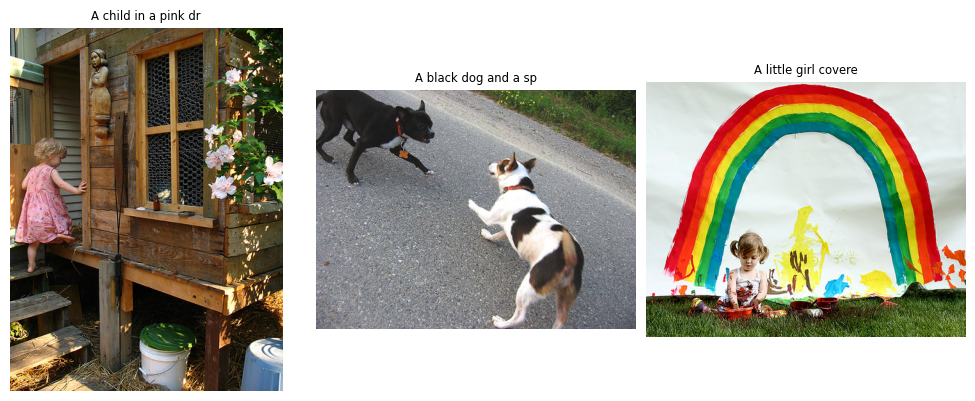

In [20]:
fig, axes = plt.subplots(1, 3, figsize = (10, 4))
for ax, name in zip(axes.flat, os.listdir(images_path)[:3]):
    img = Image.open(os.path.join(images_path, name))
    ax.imshow(img)
    ax.axis('off')
    plt.rcParams.update({'font.size':7})
    caption = captions_dict.get(name, ['No Caption Found'])[0]
    ax.set_title(caption[:20])
plt.tight_layout()
plt.show()

Image: 2071309418_1d7580b0f0.jpg

All matches:
25.27%  →  A white dog wearing a christmas reindeer headband plays with a brown dog in the grass among some stuffed animals .
24.82%  →  A white dog wearing reindeer ears is next to a brown dog .
24.62%  →  A white dog with fake antlers on its head and a brown dog play together outdoors .
25.28%  →  The white dog next to the brown dog is wearing a christmas headband .

Best Match:
25.28%  →  The white dog next to the brown dog is wearing a christmas headband .


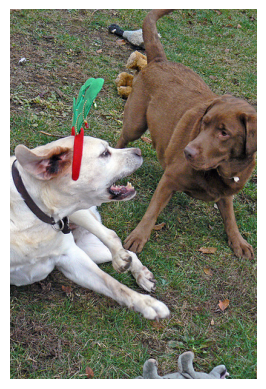

In [53]:
import random
name = random.choice(os.listdir(images_path))   # or hardcode filename
image_path = os.path.join(images_path, name)
captions = captions_dict[name]


plt.imshow(Image.open(image_path).convert("RGB"))
plt.axis('off')


best_match, all_results = clip_inference_with_confidence(
    model,
    image_path=image_path,
    candidate_texts=captions,
    device=config.device
)

print("Image:", name)
print("\nAll matches:")
for r in all_results:
    print(f"{r['confidence']:.2f}%  →  {r['caption']}")

print("\nBest Match:")
print(f"{best_match['confidence']:.2f}%  →  {best_match['caption']}")
